In [14]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from scipy import ndimage

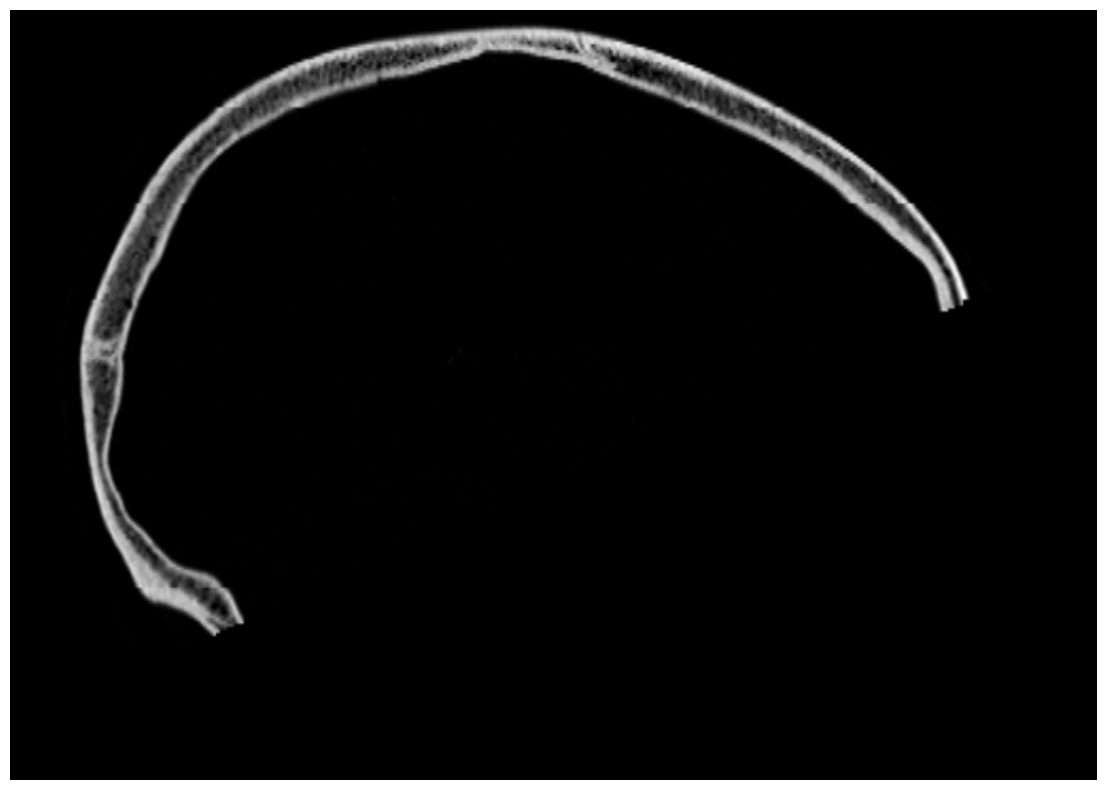

In [15]:
slice_index = 220  ### == SELECT THE SLICE TO PROCESS == ###
image_path = f'test\png_folder_sagittal_plane\Slice_{slice_index}.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(20, 10))
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show() 

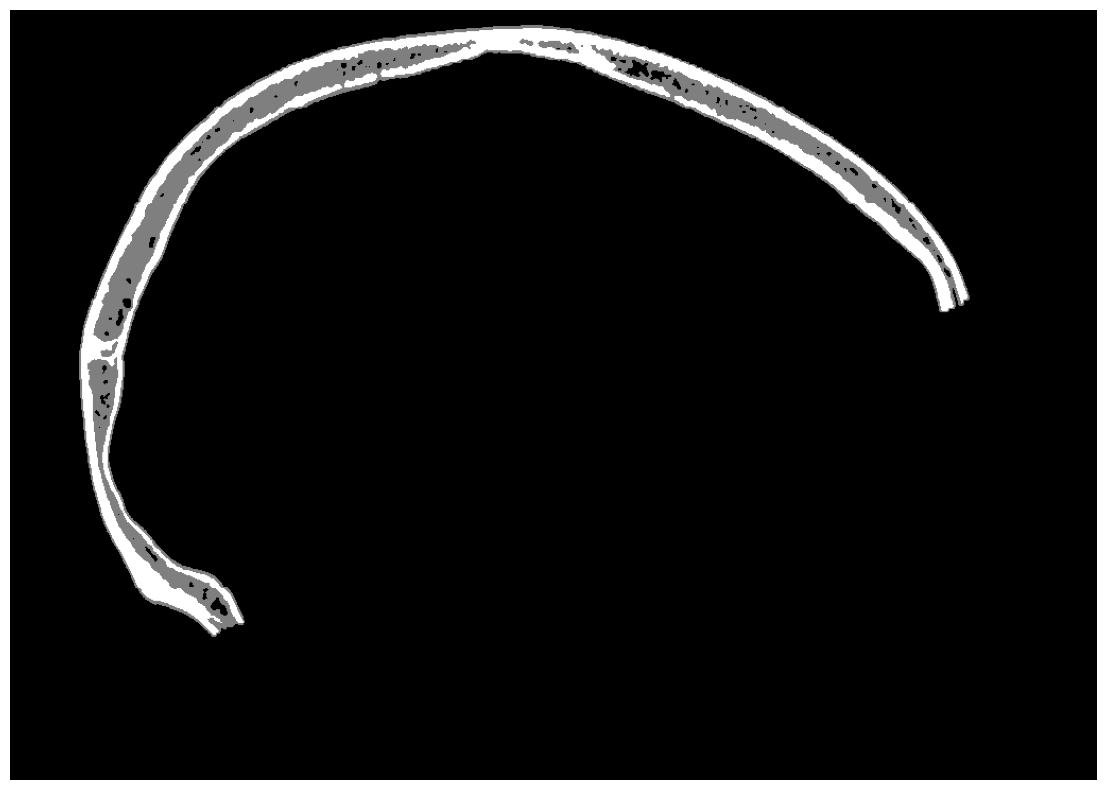

In [16]:
# Mask to exclude black pixels (background)
non_zero_mask = image > 20

# Apply K-means only on non-zero pixels
pixel_values = image[non_zero_mask].reshape((-1, 1)).astype(np.float32)
k = 2
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1)
_, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
centers = np.uint8(centers)

# Sort clusters by intensity
sorted_indices = np.argsort(centers.flatten())

# Map clusters to 127 and 255
mapped_values = np.zeros_like(labels.flatten(), dtype=np.uint8)
mapped_values[labels.flatten() == sorted_indices[0]] = 127
mapped_values[labels.flatten() == sorted_indices[1]] = 255

# Create final image: 0 (background), 127, 255
segmented_image = np.zeros_like(image, dtype=np.uint8)
segmented_image[non_zero_mask] = mapped_values

plt.figure(figsize=(20, 10))
plt.imshow(segmented_image, cmap='gray')
plt.axis('off')
plt.show()

Kernel size: 1x1, Holes detected: 79
Kernel size: 3x3, Holes detected: 36
Kernel size: 5x5, Holes detected: 4
Kernel size: 7x7, Holes detected: 2
Kernel size: 9x9, Holes detected: 0
No holes found! Closing completed.


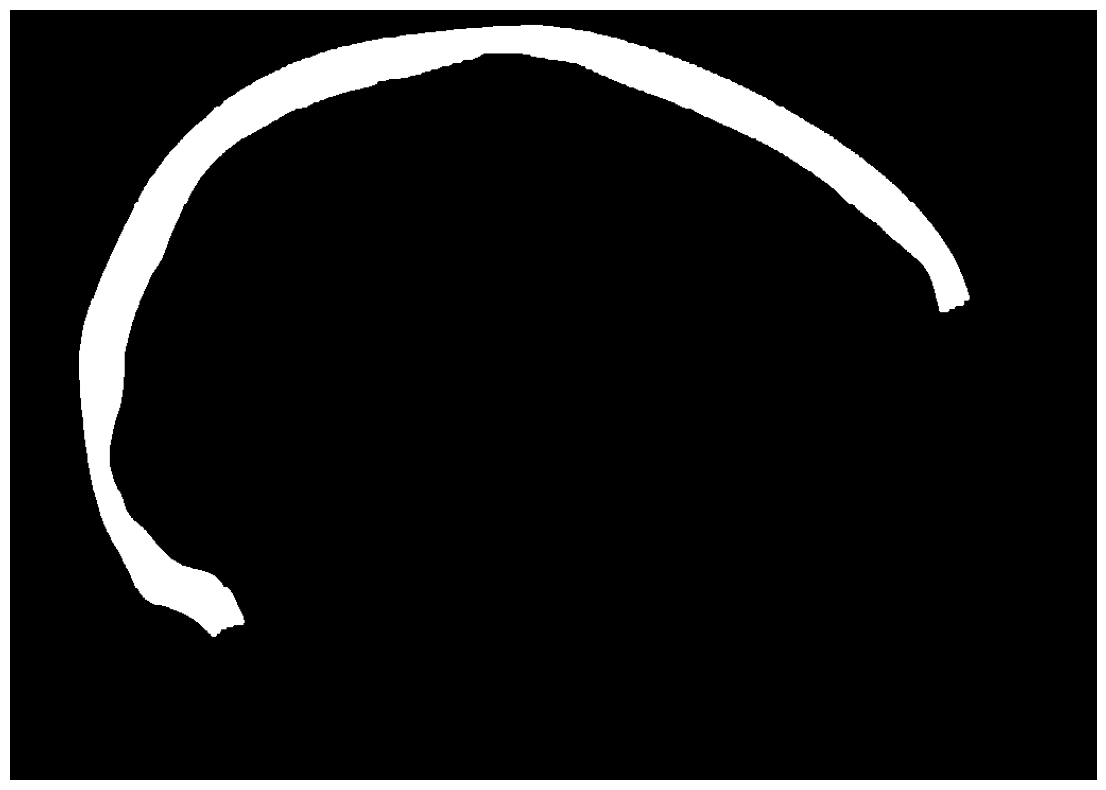

In [17]:
def count_holes(mask):
    # Find the main contour (largest white area)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return 0  # No white area found

    main_contour = max(contours, key=cv2.contourArea)

    # Create a mask only for the main white area
    main_mask = np.zeros_like(mask)
    cv2.drawContours(main_mask, [main_contour], -1, 255, thickness=cv2.FILLED)

    # Invert the original mask
    inverted = cv2.bitwise_not(mask)

    # Keep only holes inside the main area
    holes = cv2.bitwise_and(inverted, main_mask)

    # Find contours of the holes
    hole_contours, _ = cv2.findContours(holes, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    return len(hole_contours)

# Create binary mask: all values > 0 become 255
binary_mask = np.where(segmented_image > 0, 255, 0).astype(np.uint8)

kernel_size = 1
max_kernel_size = 60  # Set a reasonable max limit to avoid infinite loops

while kernel_size <= max_kernel_size:
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    skull_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

    num_holes = count_holes(skull_mask)
    print(f"Kernel size: {kernel_size}x{kernel_size}, Holes detected: {num_holes}")

    if num_holes == 0:
        print("No holes found! Closing completed.")
        break

    kernel_size += 2
else:
    print("Maximum kernel size reached without closing all holes.")

plt.figure(figsize=(20, 10))
plt.imshow(skull_mask, cmap='gray')
plt.axis('off')
plt.show()

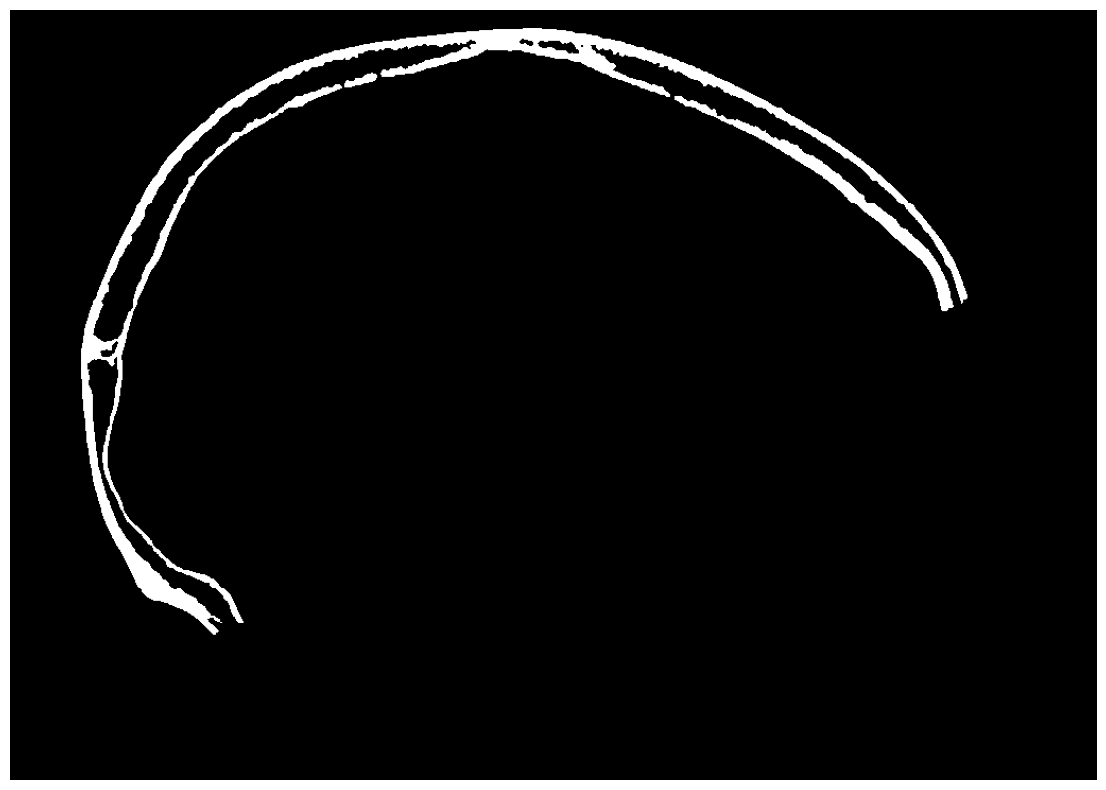

In [18]:
# Find unique cluster values
unique_values = np.unique(segmented_image)

# Identify the highest value (assumed to be bone)
bone_value = unique_values[-1]  

# Create a binary mask for the bone
bone_mask = np.isin(segmented_image, bone_value).astype(np.uint8) * 255

# Display the bone mask
plt.figure(figsize=(20, 10))
plt.imshow(bone_mask, cmap='gray')
plt.axis('off')
plt.show()

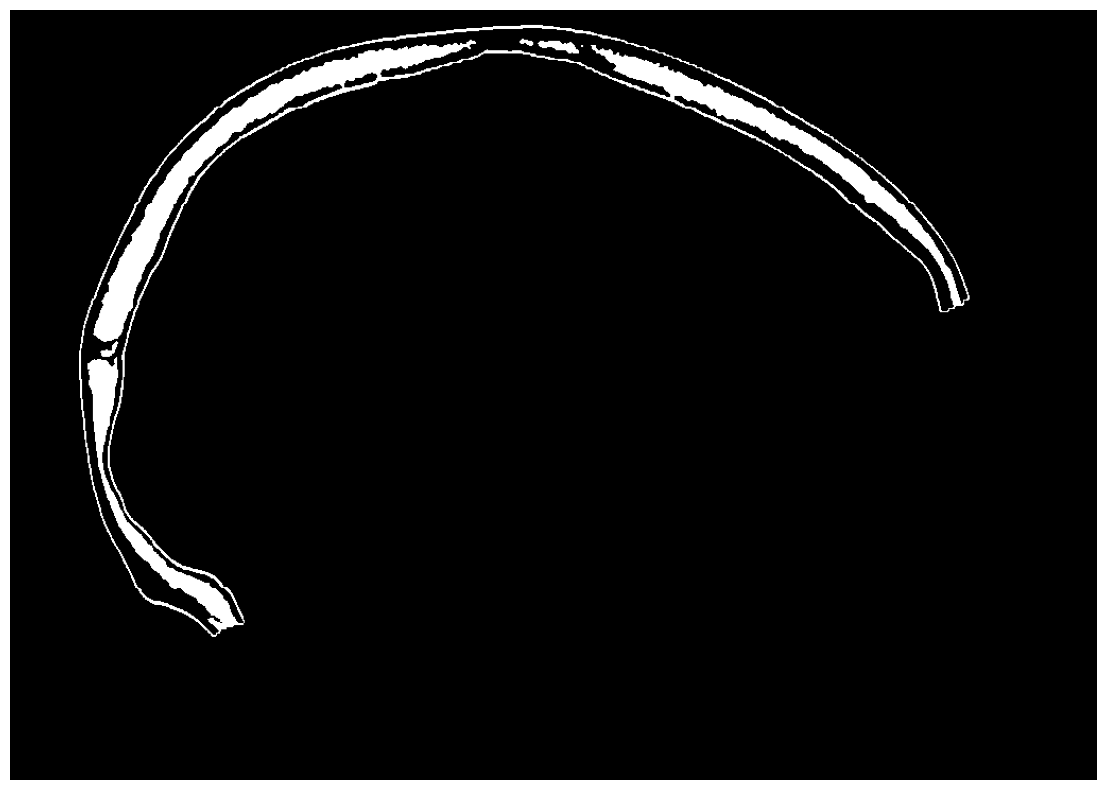

In [19]:
# Create a binary mask for the diploe
diploe_mask = cv2.subtract(skull_mask, bone_mask)

plt.figure(figsize=(20, 10))
plt.imshow(diploe_mask, cmap='gray')
plt.axis('off')
plt.show()

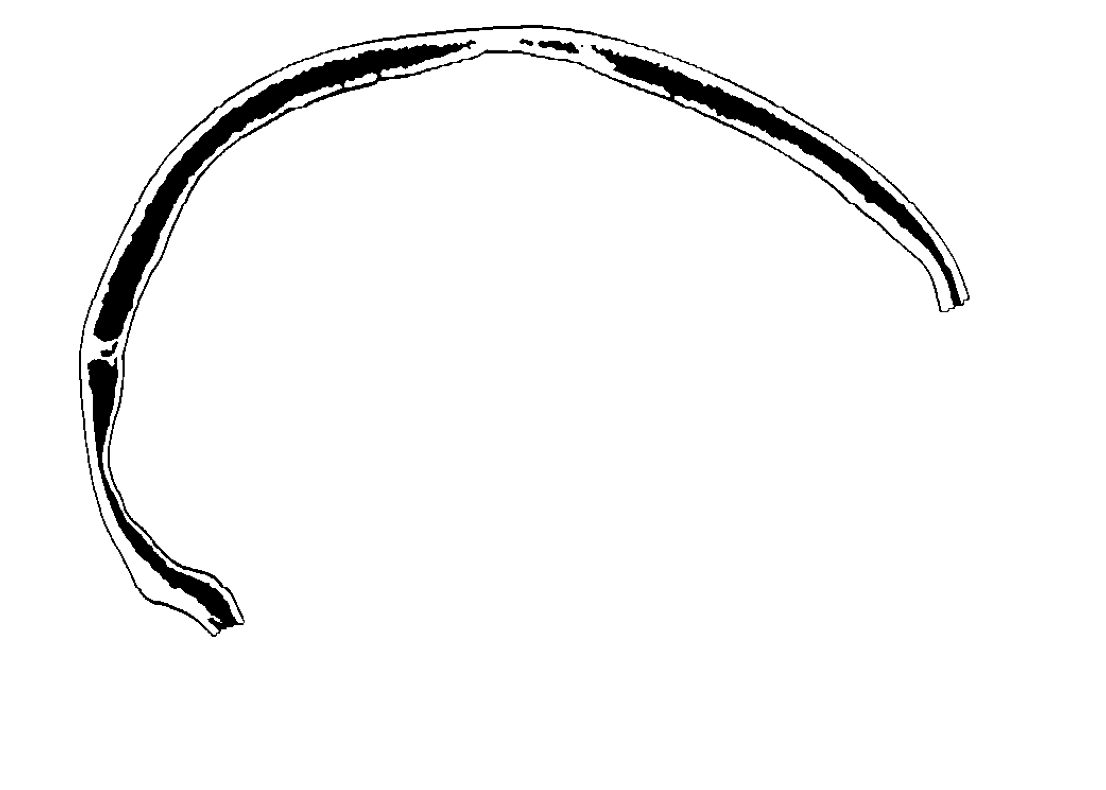

In [20]:
sure_bg = cv2.bitwise_not(diploe_mask)

plt.figure(figsize=(20, 10))
plt.imshow(sure_bg, cmap='gray')
plt.axis('off')
plt.show()

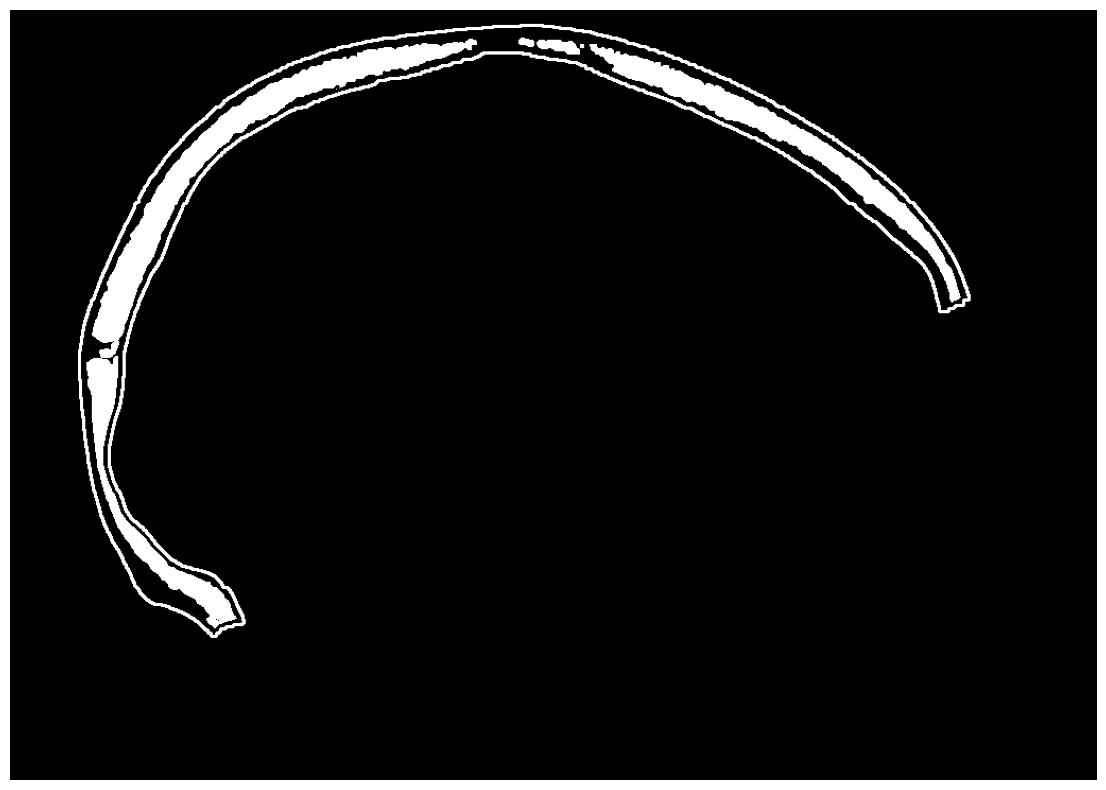

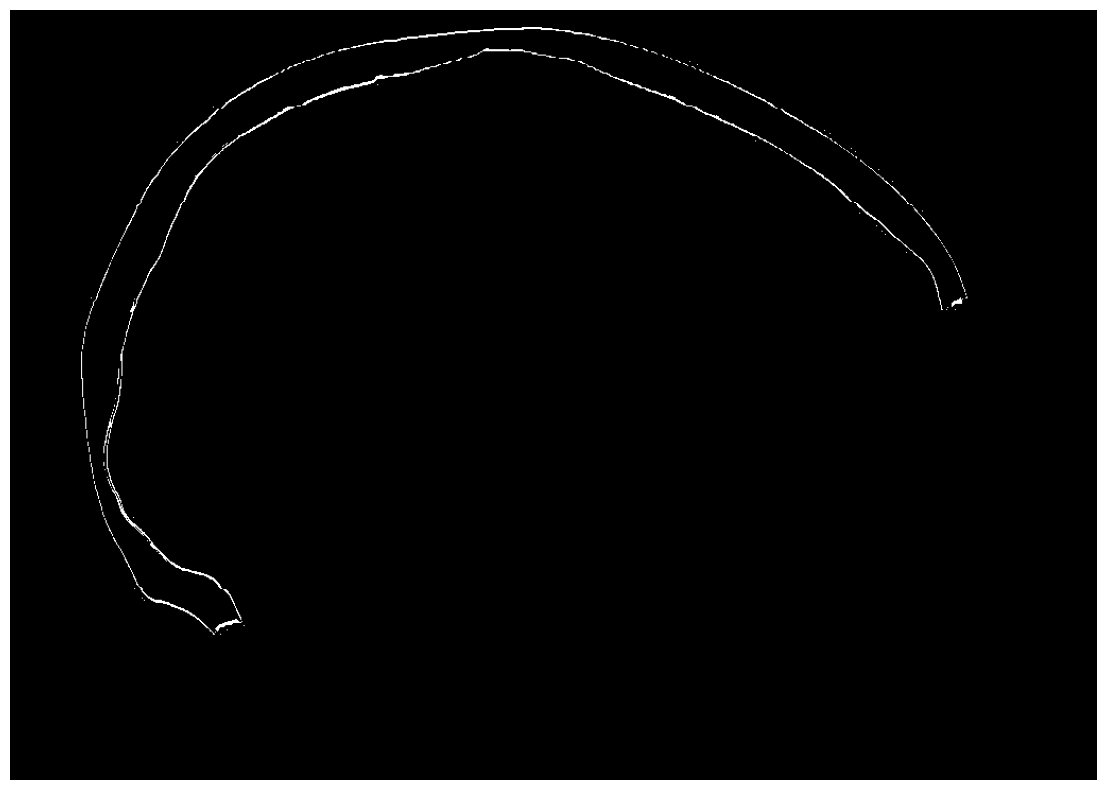

In [21]:
kernel = np.ones((3, 3), np.uint8)
diploe_mask = cv2.dilate(diploe_mask, kernel, iterations=1)

##############################################################################

# Step 1. Find the contour of the skull
contours, _ = cv2.findContours(skull_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Step 2. Create an empty image with the same size as diploe_mask
contour_full = np.zeros_like(diploe_mask)

# Step 3. Draw a thick contour (half inside, half outside)
cv2.drawContours(contour_full, contours, -1, color=255, thickness=2)

# Step 4. Keep only the inner part of the contour
external_contour = cv2.bitwise_and(contour_full, diploe_mask)

##############################################################################

# Step 1: Find contours of the diploe mask
contours, _ = cv2.findContours(diploe_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 2: Create an empty mask to draw the contours
border_mask = np.zeros_like(diploe_mask)

# Step 3: Draw thick contours (12-pixel width) on the border mask
cv2.drawContours(border_mask, contours, -1, color=255, thickness=12)

# Step 4: Subtract contour border from diploe_mask to isolate the inner region
inner_mask = cv2.subtract(diploe_mask, border_mask)

# Combine certain foreground areas
sure_fg = cv2.bitwise_or(external_contour, inner_mask)

# Define uncertain regions (unknown areas)
unknown = cv2.subtract(diploe_mask, sure_fg)

# Display certain foreground
plt.figure(figsize=(20, 10))
plt.imshow(sure_fg, cmap='gray')
plt.axis('off')
plt.show()

# Display unknown areas
plt.figure(figsize=(20, 10))
plt.imshow(unknown, cmap='gray')
plt.axis('off')
plt.show()

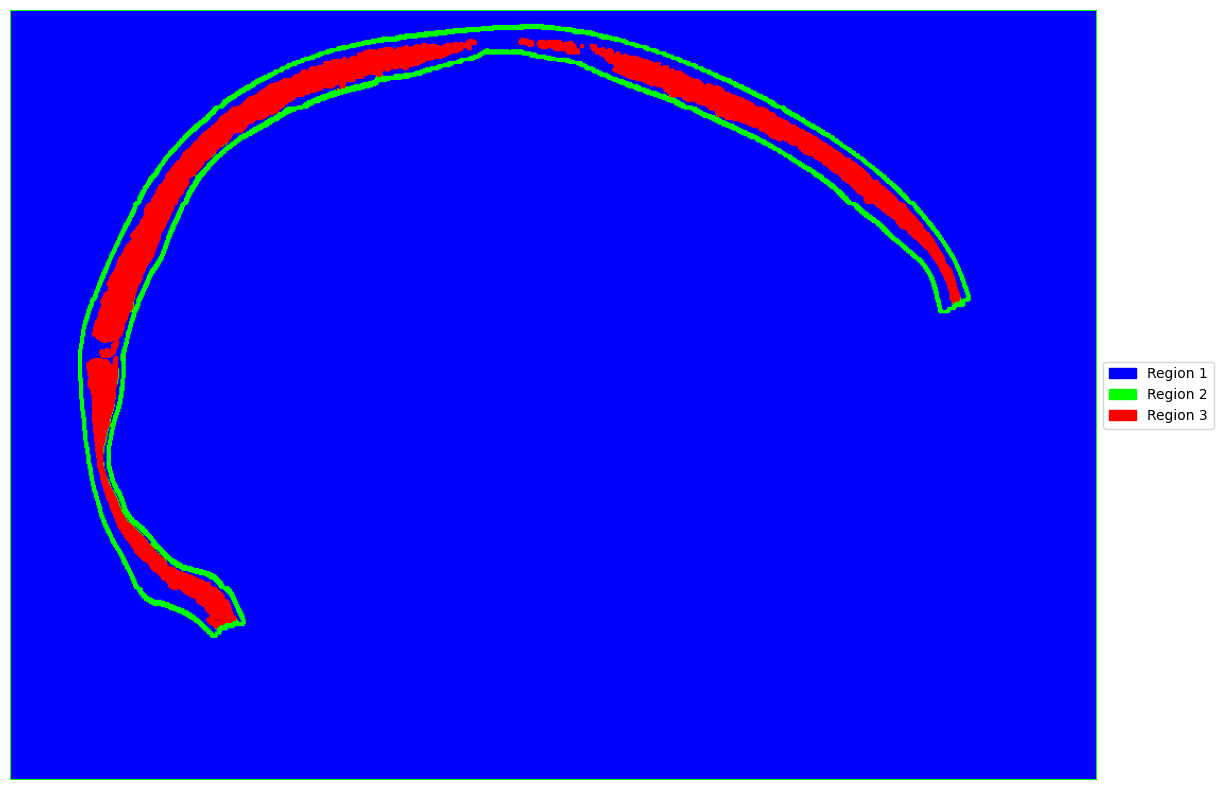

In [22]:
# Step 1: Create label image (same size as diploe_mask)
labels = np.zeros_like(diploe_mask, dtype=np.int32)

# Step 2: Assign labels to the known regions
labels[external_contour == 255] = 1  # External contour
labels[inner_mask == 255] = 2        # Inner region

# Step 3: Increment all labels by 1 so background becomes 1 (non-zero)
markers = labels + 1

# Step 4: Set unknown regions to 0 (watershed will treat them as uncertain)
markers[unknown == 255] = 0

# Step 5: Convert diploe mask to BGR for watershed input
img_color = cv2.cvtColor(diploe_mask, cv2.COLOR_GRAY2BGR)

# Step 6: Apply watershed algorithm
markers = cv2.watershed(img_color, markers.astype(np.int32))

# Step 7: Visualize the result
num_regions = markers.max()

# Define custom RGB colors for each region
custom_colors = [
    (0, 0, 255),     # Region 1 - Red
    (0, 255, 0),     # Region 2 - Green
    (255, 0, 0),     # Region 3 - Blue
    (255, 255, 0),   # Region 4 - Yellow
    (255, 0, 255),   # Region 5 - Magenta
    (0, 255, 255),   # Region 6 - Cyan
    # Add more colors if needed for more regions
]

# Create output image for segmentation
segmented_img = np.zeros((*markers.shape, 3), dtype=np.uint8)
legend_patches = []

# Assign colors to each region
for label in range(1, num_regions + 1):
    color_rgb = custom_colors[label - 1] if label - 1 < len(custom_colors) else (128, 128, 128)
    segmented_img[markers == label] = color_rgb

    # Add region label to legend
    patch = mpatches.Patch(color=np.array(color_rgb) / 255, label=f'Region {label}')
    legend_patches.append(patch)

# Highlight watershed borders in green
segmented_img[markers == -1] = [0, 255, 0]

# Display segmented image
plt.figure(figsize=(20, 10))
plt.imshow(segmented_img)
plt.axis('off')
plt.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

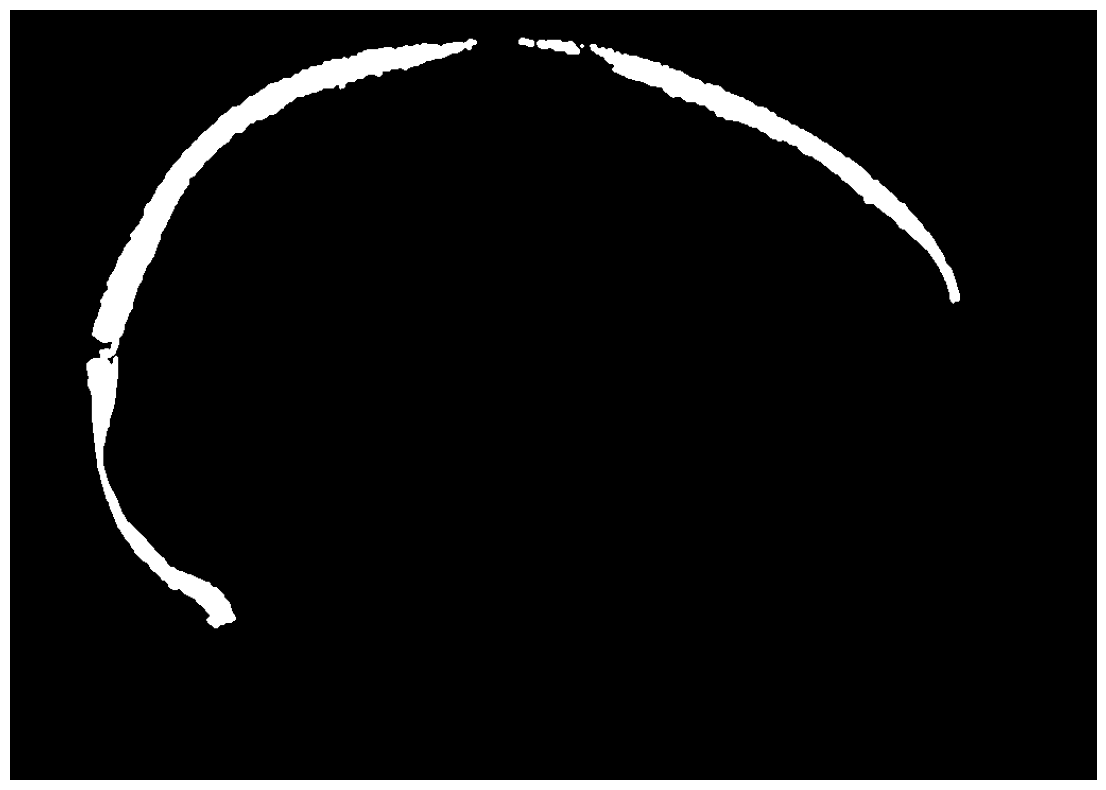

In [23]:
# Step 1: Include both region 2 (markers == 2) and watershed borders (markers == -1)
noise_contour_mask = np.logical_or(markers == 2, markers == -1).astype(np.uint8) * 255

# Step 2: Subtract the unwanted regions from the original diploe mask
diploe_minus_region2 = cv2.subtract(diploe_mask, noise_contour_mask)

# Step 3: Fill internal holes in the result
filled_diploe_mask = ndimage.binary_fill_holes(diploe_minus_region2).astype(np.uint8) * 255

# Step 4: Apply median filtering to smooth the mask
final_diploe_mask = cv2.medianBlur(filled_diploe_mask, 3)  # 3x3 kernel

# Step 5: Display the result
plt.figure(figsize=(20, 10))
plt.imshow(final_diploe_mask, cmap='gray')
plt.axis('off')
plt.show()

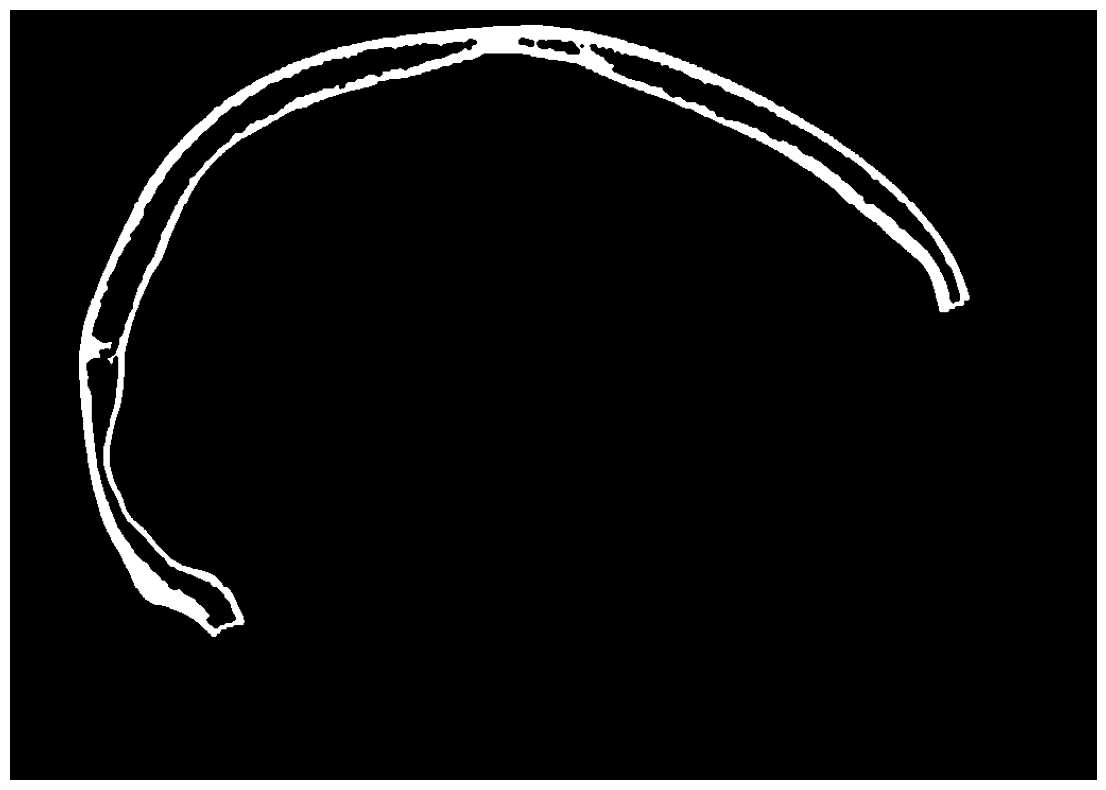

In [24]:
# Create the final binary mask for the bone
final_bone_mask = cv2.subtract(skull_mask, final_diploe_mask)

# Visualizza il risultato
plt.figure(figsize=(20, 10))
plt.imshow(final_bone_mask, cmap='gray')
plt.axis('off')
plt.show()

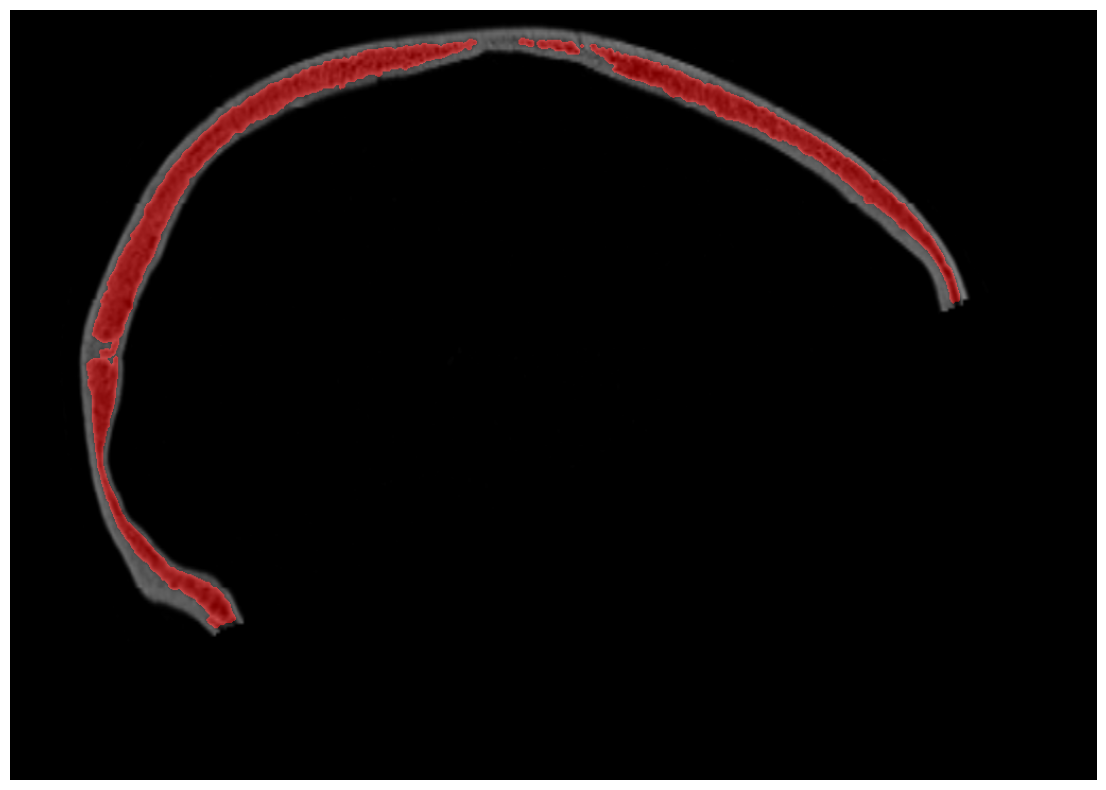

In [25]:
# Colors for masks (in BGR format)
red = (255, 0, 0)  # Red

# Display the result with mask overlay
plt.figure(figsize=(20, 10))
plt.imshow(image, cmap='gray')  # Base grayscale image
plt.imshow(np.where(final_diploe_mask[..., None] > 0, red, [0, 0, 0]) / 255, alpha=0.5)  # Overlay in red
plt.axis('off')
plt.show()

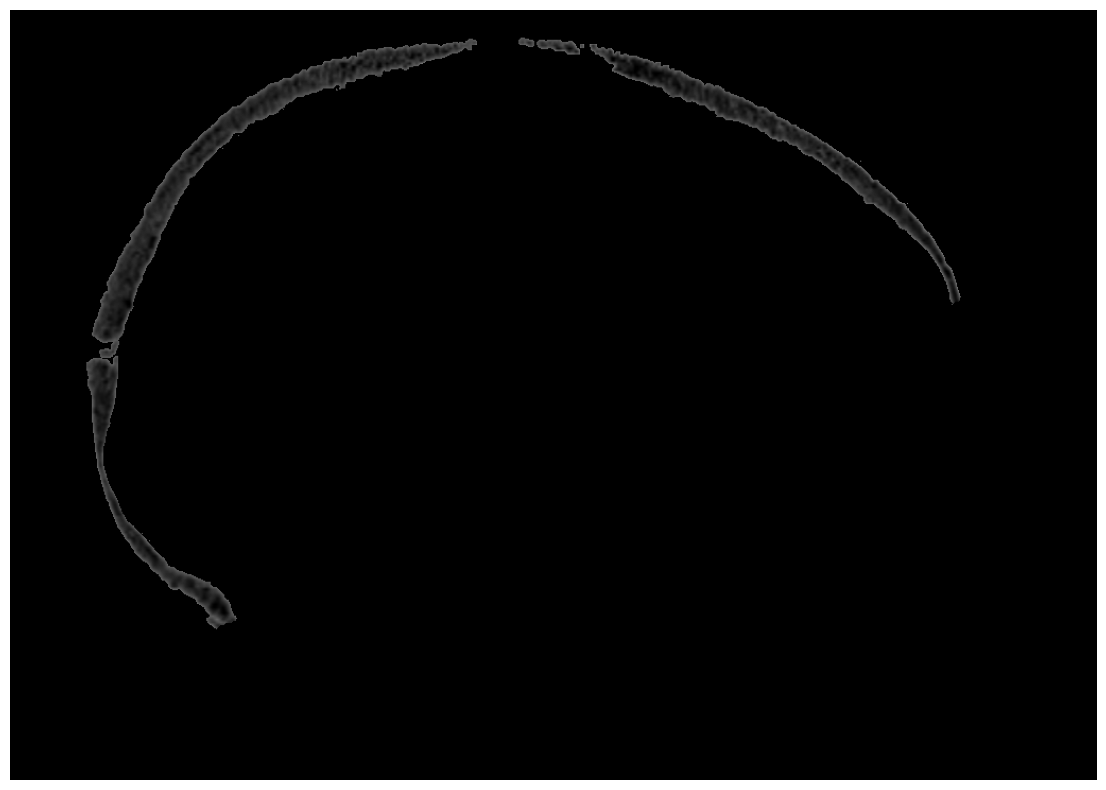

In [26]:
# Get the image dimensions
height, width = image.shape

# Create a black image of the same size
black_image = np.zeros((height, width), dtype=np.uint8)

# Apply the filled diploe mask to extract the diploe region from the image
diploe_seg = cv2.bitwise_or(image, black_image, mask=filled_diploe_mask)

# Display the segmented diploe region
plt.figure(figsize=(20, 10))
plt.imshow(diploe_seg, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()